# Árbol de decisión
## Minería de datos - Grupo 2ASJ

## Librerías y herramientas




*Importamos* aquellas herramientas y librerías que hemos necesitado para poder trabajar en este cuaderno.

In [ ]:
!apt-get -qq install -y graphviz && pip install -q pydot

In [ ]:
# Data load and manipulation
from google.colab import files
import io
 
# DataFrame librery
import pandas as pd
 
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pydot

# Basic Operations
import numpy as np
from numpy import corrcoef, transpose
import itertools
import operator
 
# Models
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


## Carga de datos

Definimos un método para poder cargar los datos, y posteriormente cargamos la tarjeta de datos.

In [ ]:
def upload_files (index_fields = None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    if index_fields:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    else:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
print("Por favor, sube el fichero 'X_train.csv'")
X_train = upload_files()
X_train.head()

Por favor, sube el fichero 'X_train.csv'


Saving X_train.csv to X_train.csv
User uploaded file "X_train.csv" with length 14344678 bytes


,number_developer_games,median_playtime,price_x,Massively Multiplayer,Adventure,RAM,owners,achievements,required_age,Online Co-op,Gore,Simulation,Action,Cross-Platform Multiplayer,Online Multi-Player,Co-op,Strategy,Indie,Steam Achievements,Sexual Content,Sports,Full controller support,Steam Trading Cards,2d_y,access,action_y,adventure_y,ammo,animation,anyone,arcade_y,armor,array,art,atmospheric_y,awardwinning,battle,beautiful_y,become,blend,...,RB,VB,num_oraciones,negative,positive,1990s,anime,base_building,co_op,comedy,dark_fantasy,female_protagonist,first_person,free_to_play,gore,great_soundtrack,hand_drawn,interactive_fiction,isometric,local_co_op,local_multiplayer,moba,massively_multiplayer,mature,metroidvania,minimalist,moddable,open_world,pixel_graphics,robots,rogue_like,rogue_lite,sci_fi,sexual_content,shoot_em_up,side_scroller,story_rich,typing,vr_only,visual_novel
0,0.000000,0.000068,0.000000,1.0,0.0,0.002000,0.000433,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.298291,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139252,0.0,0.000000,0.0,0.000000,0.0,...,0.123138,0.038988,0.017544,0.02375,0.363,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.050926,0.000000,0.267622,0.0,0.0,0.0,0.0,0.0,0.0,0.194847,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.001773,0.003762,0.0,0.0,0.000256,0.000433,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.234662,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.332676,0.0,...,0.102708,0.086719,0.031579,0.47375,0.020,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.680308,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.019001,0.0,1.0,0.001000,0.000000,0.001935,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.076897,0.000000,0.185747,0.088820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.181852,0.0,0.000000,0.0,...,0.021099,0.053444,0.024561,0.34250,0.030,0.0,0.0,0.0,0.0,0.171875,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.137222,0.0,0.0,0.0,0.0,0.0,0.131404,0.0,0.107692,0.0,0.0,0.0
3,0.032258,0.002324,0.014239,0.0,0.0,0.002000,0.000000,0.001731,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.107799,0.000000,0.362711,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.073004,0.046230,0.017544,0.30875,0.158,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.503115,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.021505,0.006825,0.052336,0.0,1.0,0.000500,0.002267,0.004277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.178744,0.020462,0.090838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068360,0.0,0.097464,0.0,0.000000,0.0,...,0.107056,0.067793,0.066667,0.36750,0.184,0.0,0.0,0.0,0.0,0.000000,0.0,0.337801,0.0,0.000000,0.000000,0.094658,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [ ]:
print("Por favor, sube el fichero 'y_train.csv'")
y_train = upload_files()
y_train.head()

Por favor, sube el fichero 'y_train.csv'


Saving y_train.csv to y_train.csv
User uploaded file "y_train.csv" with length 22529 bytes


,target_x
0,3
1,0
2,1
3,1
4,1


In [ ]:
print("Por favor, sube el fichero 'X_test.csv'")
X_test = upload_files()
X_test.head()

Por favor, sube el fichero 'X_test.csv'


Saving X_test.csv to X_test.csv
User uploaded file "X_test.csv" with length 7080967 bytes


,number_developer_games,median_playtime,price_x,Massively Multiplayer,Adventure,RAM,owners,achievements,required_age,Online Co-op,Gore,Simulation,Action,Cross-Platform Multiplayer,Online Multi-Player,Co-op,Strategy,Indie,Steam Achievements,Sexual Content,Sports,Full controller support,Steam Trading Cards,2d_y,access,action_y,adventure_y,ammo,animation,anyone,arcade_y,armor,array,art,atmospheric_y,awardwinning,battle,beautiful_y,become,blend,...,RB,VB,num_oraciones,negative,positive,1990s,anime,base_building,co_op,comedy,dark_fantasy,female_protagonist,first_person,free_to_play,gore,great_soundtrack,hand_drawn,interactive_fiction,isometric,local_co_op,local_multiplayer,moba,massively_multiplayer,mature,metroidvania,minimalist,moddable,open_world,pixel_graphics,robots,rogue_like,rogue_lite,sci_fi,sexual_content,shoot_em_up,side_scroller,story_rich,typing,vr_only,visual_novel
0,0.032258,0.001107,0.119006,0.0,0.0,0.000500,0.049937,0.007942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.038759,0.081033,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.120144,0.000000,0.000000,0.0,0.000000,0.0,...,0.109261,0.053223,0.007018,0.24000,0.157,0.0,0.0,0.0,0.0,0.0,0.280422,0.000000,0.0,0.0,0.0,0.176349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286343,0.000000,0.0,0.0,0.397994,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.251331,0.0,0.00,0.0
1,0.290323,0.001742,0.019001,0.0,1.0,0.002000,0.000933,0.001324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.143998,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.117732,0.0,0.000000,0.0,...,0.096156,0.048713,0.080702,0.35250,0.198,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
2,0.000000,0.000000,0.033287,0.0,0.0,0.000256,0.000000,0.002851,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.317772,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.172773,0.0,0.000000,0.0,...,0.067131,0.113362,0.052632,0.44375,0.154,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
3,0.000000,0.000000,0.034240,0.0,0.0,0.000500,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.388260,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.062416,0.000000,0.021053,0.33125,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.52,0.0
4,0.010753,0.000330,0.064241,0.0,1.0,0.001000,0.000167,0.003767,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.251318,0.172822,0.0,0.0,0.216136,0.0,0.0,0.0,0.0,0.000000,0.172679,0.000000,0.0,0.159032,0.0,...,0.086904,0.047170,0.059649,0.12500,0.185,0.0,0.0,0.0,0.0,0.0,0.000000,0.169383,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.218868,0.0,0.0,0.000000,0.0,0.295148,0.0,0.0,0.204178,0.0,0.0,0.0,0.243832,0.0,0.00,0.0


In [ ]:
print("Por favor, sube el fichero 'y_test.csv'")
y_test = upload_files()
y_test.head()

Por favor, sube el fichero 'y_test.csv'


Saving y_test.csv to y_test.csv
User uploaded file "y_test.csv" with length 11103 bytes


,target_x
0,3
1,1
2,2
3,2
4,2


## El modelo

Necesitamos optimizar algunos parámetros del DecisionTree, siendo estos la profrundifad máxima o el criterio. Para ello, utilizaremos la validación de KFold.

Otros parametros:
* criterio: La función para medir la calidad de una división. Los criterios admitidos son "gini" para la impureza de Gini y la "entropía" para la ganancia de información.
* min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno 
* min_samples_leaf: El número mínimo de muestras necesarias para estar en un nodo hoja (suavizado el efecto en regresión)
* class_weight: Pesos asociados a las clases. El modo "balanced" utiliza los valores de y para ajustar automáticamente los pesos inversamente proporcionales a las frecuencias de clase en los datos de entrada

In [ ]:
# Cross Validator
cv = KFold(n_splits = 10, shuffle = False)

# Estructura de datos para guardar el accuracy de cada modelo
accuracies = {
    'gini':[],
    'entropy':[]
}

# Establecemos un rango de profundidades para el árbol, sobre el que iremos probando valores
depth_range = range(1, 15)

# Recorremos combinaciones de criterios y de profundidades
for crit in ['gini', 'entropy']:
  for depth in depth_range:

      fold_accuracy = []

      # Para cada combinación creamos un árbol de decisión
      tree_model = tree.DecisionTreeClassifier(criterion=crit, 
                                              min_samples_split = 2, 
                                              min_samples_leaf = 0.05,
                                              max_depth = depth
                                              )
      
      # Validamos dicho árbol mediante validación cruzada
      for train_fold, validation_fold in cv.split(X_train):
          X__train = X_train.loc[train_fold]
          X__val = X_train.loc[validation_fold]
          y__train = y_train.loc[train_fold]
          y__val = y_train.loc[validation_fold]
          
          model = tree_model.fit(X=X__train, y=y__train)
          val_acc = model.score(X=X__val, y=y__val)
          
          fold_accuracy.append(val_acc)
        
      # Añadimos la precisión media en validación a una estructura de datos
      avg = sum(fold_accuracy)/len(fold_accuracy)
      accuracies[crit].append(avg)

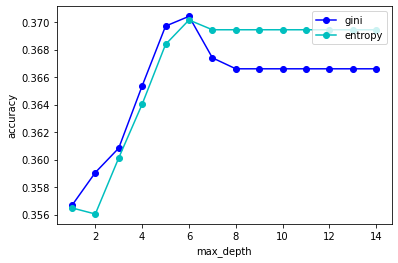

In [ ]:
# Creamos una gráfica en la que comparra la precisión segun la profundidad y la entropía
plt.plot(depth_range, accuracies['gini'], marker='o', color = 'b')
plt.plot(depth_range, accuracies['entropy'], marker='o', color = 'c')
plt.legend(['gini', 'entropy'], loc='upper right')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

Creamos un modelo seleccionando como criterio la entropía con una profundidad max de 5 con el objetivo de que sea traceable a de perder en precisión. Además tomamos como mínimo un 3% de aparición para tener en cuenta una hoja. 

In [ ]:
# Creamos el mejor modelo
best_model = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 2, 
                                  min_samples_leaf = 0.03, max_depth = 5)

# Entrenamiento del modelo
best_model.fit(X_train, y_train)

# Predecimos sobre el conjunto de datos de test
y_pred = best_model.predict(X_test) 

Mostramos el rendimiento de nuestro mejor estimador utilizando el informe de clasificación proporcionado por Scikit Learn.

In [ ]:
# Mostramos los resultados del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.14      0.21      1225
           1       0.37      0.74      0.49      1890
           2       0.32      0.12      0.18      1336
           3       0.34      0.26      0.30      1096

    accuracy                           0.36      5547
   macro avg       0.37      0.32      0.29      5547
weighted avg       0.37      0.36      0.31      5547



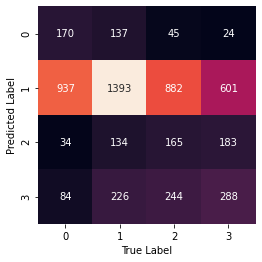

In [ ]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0, 1, 2, 3],
            yticklabels=[0, 1, 2, 3])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

##Visualización

Por último, mostramos el arbol de decisión generado.

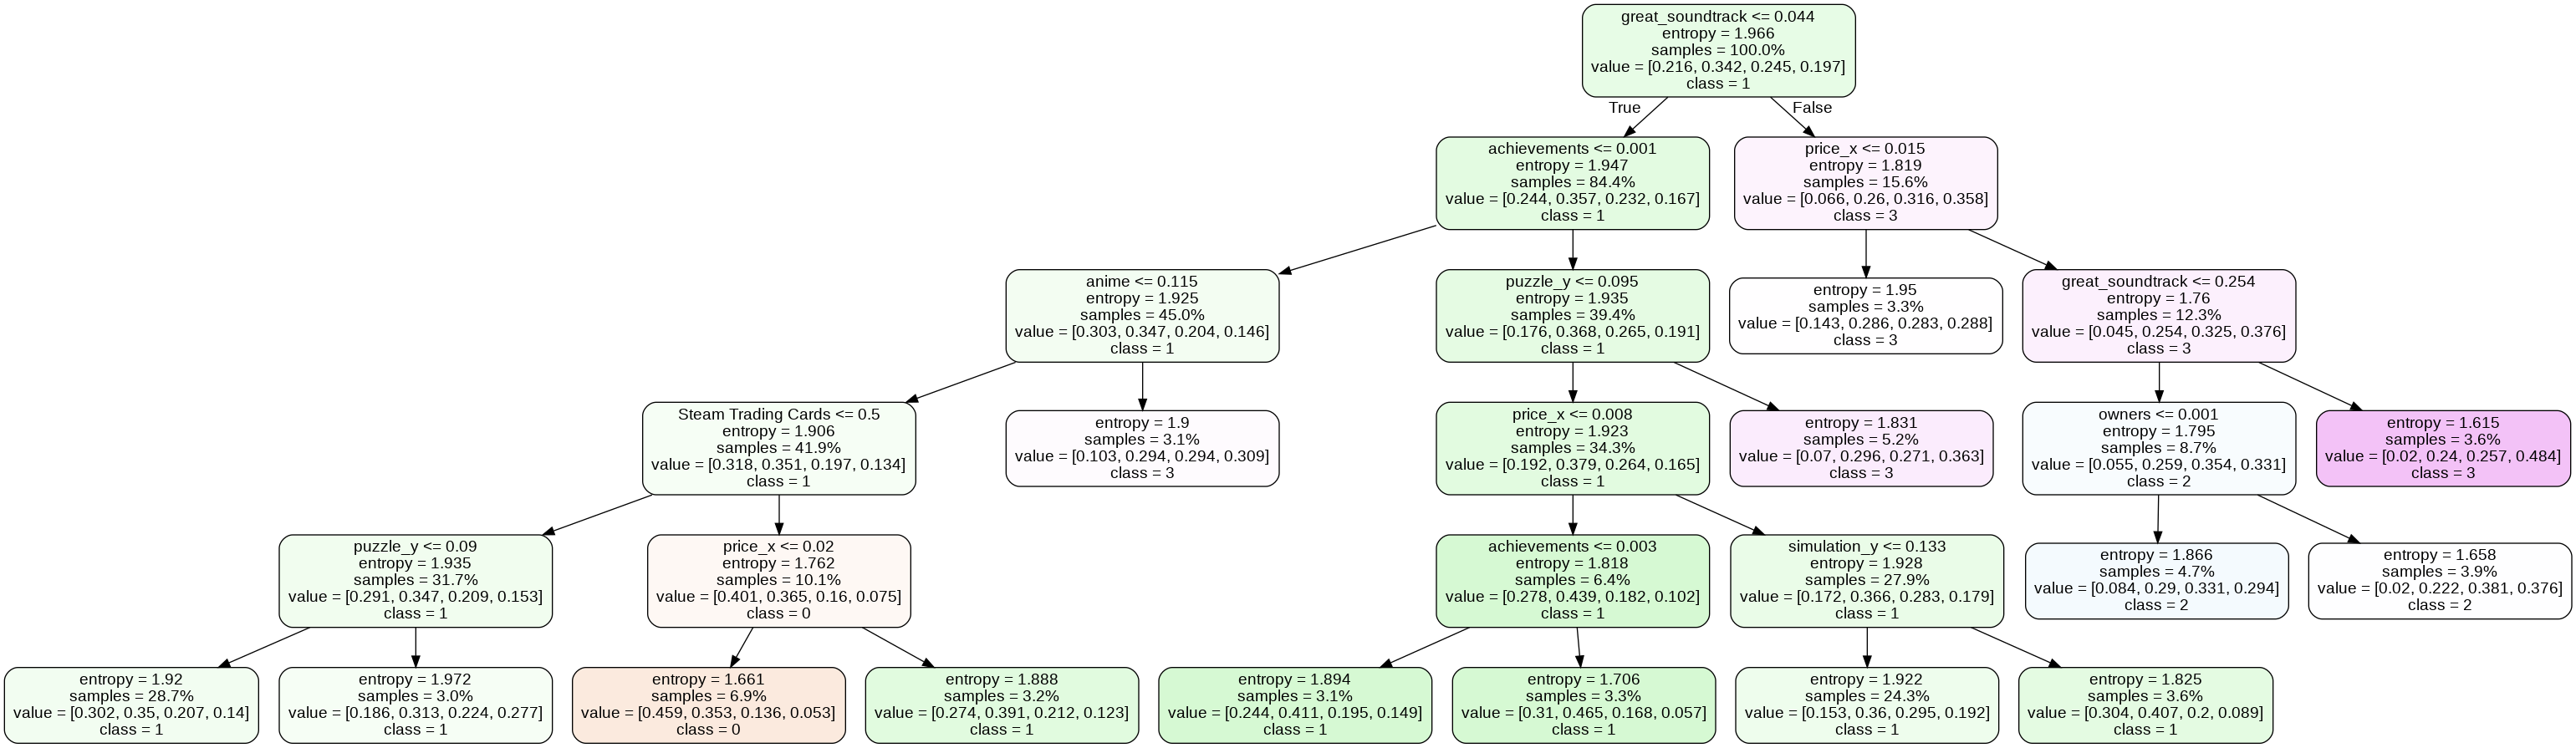

In [ ]:
from IPython.display import Image

from io import StringIO

dot_data = StringIO()
#tree.export_graphviz(best_model, out_file=dot_data, feature_names=list(spy.drop(['CLASIFICADOR'], axis=1)))
tree.export_graphviz(best_model, out_file = dot_data, proportion = True,
                     feature_names=list(X_train.columns), 
                     class_names = ['0', '1', '2', '3'], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())